#1. 데이터 분석하기

In [8]:
import pandas as pd
import numpy as np
from scipy import stats

df = pd.read_csv("/content/4주차_imu_trimmed_data.csv")

###1. 결측치 처리

In [2]:
# 1. 전체에 결측치가 하나라도 있는가?
has_missing = df.isnull().values.any()
print("Is there any missing value in the dataset?:", has_missing)

Is there any missing value in the dataset?: False


In [3]:
# 2. 열별 결측치 개수
missing_by_column = df.isnull().sum()
print("Missing values by column:")
print(missing_by_column)

Missing values by column:
time       0
accel_x    0
accel_y    0
accel_z    0
gyro_x     0
gyro_y     0
gyro_z     0
mag_x      0
mag_y      0
mag_z      0
pos_x      0
pos_y      0
pos_z      0
roll       0
pitch      0
yaw        0
dtype: int64


In [4]:
# 3. 전체 결측치 개수 및 비율
total_cells = df.shape[0] * df.shape[1]
total_missing = missing_by_column.sum()
missing_ratio = total_missing / total_cells * 100
print(f"Total missing: {total_missing} cells ({missing_ratio:.2f}%)")

Total missing: 0 cells (0.00%)


###2. 이상치 처리

In [5]:
def detect_outliers_zscore(df, threshold=3, cols=None):
    """
    Z-Score 방식으로 이상치 탐지: 절댓값(z-score) > threshold 인 행 리턴
    """
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    z = np.abs(stats.zscore(df[cols].dropna()))  # NaN 제외한 수치 열들
    mask = (z > threshold).any(axis=1)  # 어느 열이라도 조건 넘으면 True
    return df[mask]

def detect_outliers_iqr(df, cols=None, factor=1.5):
    """
    IQR 방식으로 이상치 탐지: Q1 − factor*IQR, Q3 + factor*IQR 벗어나는 값 리턴
    """
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    outlier_mask = pd.Series(False, index=df.index)
    for c in cols:
        Q1 = df[c].quantile(0.25)
        Q3 = df[c].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        mask_c = (df[c] < lower) | (df[c] > upper)
        outlier_mask = outlier_mask | mask_c
    return df[outlier_mask]

In [9]:
# Z-Score 방식으로 이상치 탐지
outliers_z = detect_outliers_zscore(df, threshold=3, cols=["accel_x", "accel_y", "gyro_x", "gyro_y"])

# IQR 방식으로 이상치 탐지
outliers_iqr = detect_outliers_iqr(df, cols=["accel_x", "accel_y", "gyro_x", "gyro_y"])

print("Z-Score 이상치 수:", len(outliers_z))
print("IQR 이상치 수:", len(outliers_iqr))

Z-Score 이상치 수: 2911
IQR 이상치 수: 11007


###3. 이동 평균

In [10]:
def apply_moving_average(df, cols, window=5, center=False):
    # 코드 입력하기
    df_out = df.copy()
    for c in cols:
        ma_col = f"{c}_ma"
        df_out[ma_col] = df_out[c].rolling(window=window, center=center, min_periods=1).mean()
    return df_out

In [12]:

sensor_cols = ["accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"]  # 실제 열 이름 확인 필요
df_smoothed = apply_moving_average(df, sensor_cols, window=5)

# 결과 확인
print(df.head())
print(df_smoothed.head())

       time    accel_x   accel_y    accel_z    gyro_x    gyro_y    gyro_z  \
0  0.000000   0.121071  0.055025   0.140186 -0.011067 -0.010805 -0.008495   
1  0.041667  39.966154  3.545544  19.797705  0.007095  1.721180 -0.001495   
2  0.083333  39.566765  3.349085  19.823509  0.013853  3.273903  0.006014   
3  0.125000  38.904918  3.489621  19.632148  0.010623  4.512130  0.008366   
4  0.166667  38.078029  3.257572  19.255620  0.017377  5.320870 -0.008266   

      mag_x     mag_y     mag_z     pos_x     pos_y      pos_z  roll  \
0  0.035449 -0.019849 -1.021133  0.000000  0.000000  15.000000   0.0   
1 -0.089663 -0.003195 -0.985548  0.028591 -0.005469  15.014972  -0.0   
2  0.114359 -0.020547 -0.968094  0.126325 -0.004862  15.064497  -0.0   
3  0.377211 -0.040452 -1.012608  0.292470  0.001808  15.148276  -0.0   
4  0.561203 -0.080181 -0.925415  0.525857  0.014487  15.265840  -0.0   

      pitch  yaw  
0 -0.000000  0.0  
1  0.039803 -0.0  
2  0.148070 -0.0  
3  0.314185 -0.0  
4  0.5220

#2. 데이터 분석

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

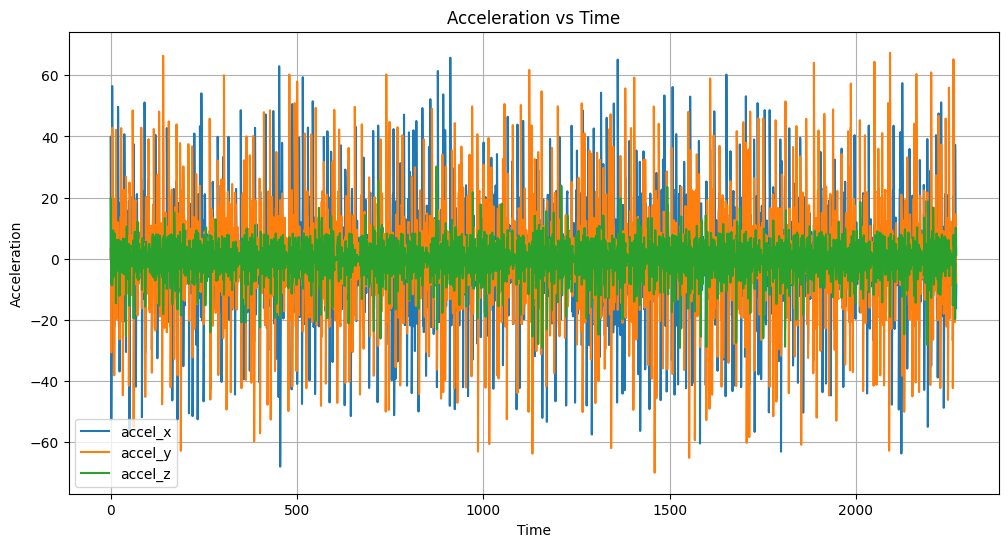

In [14]:
# 1) 라인 플롯: 시간 대비 가속도 X, Y, Z
plt.figure(figsize=(12, 6))
plt.plot(df["time"], df["accel_x"], label="accel_x")
plt.plot(df["time"], df["accel_y"], label="accel_y")
plt.plot(df["time"], df["accel_z"], label="accel_z")
plt.xlabel("Time")
plt.ylabel("Acceleration")
plt.title("Acceleration vs Time")
plt.legend()
plt.grid()
plt.show()

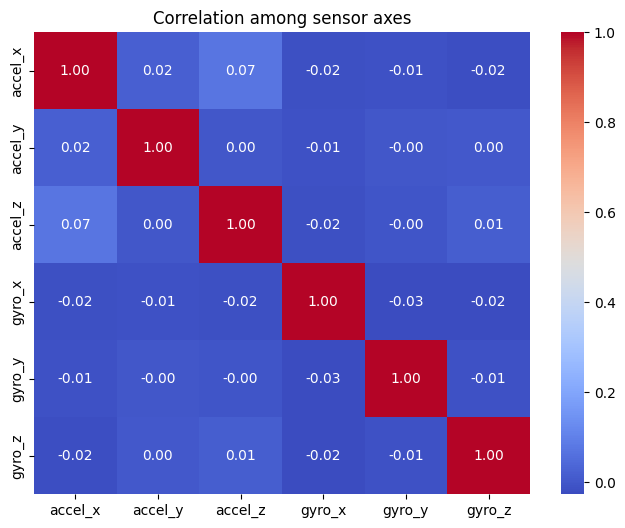

In [15]:
# 2) 히트맵: 센서 값 간 상관관계
sensor_cols = ["accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"]
corr = df[sensor_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation among sensor axes")
plt.show()

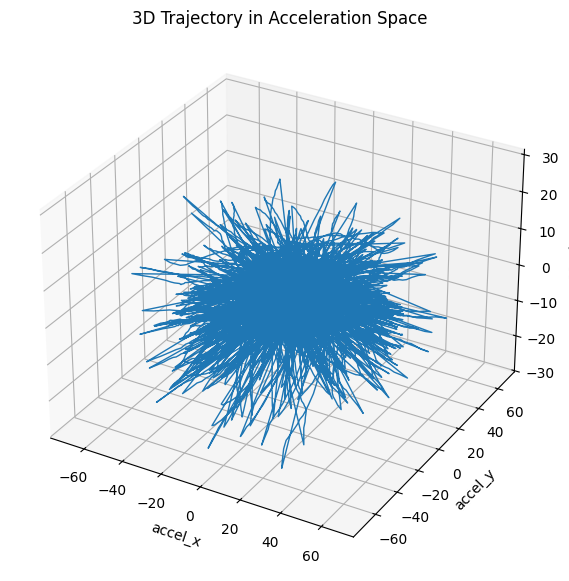

In [16]:
# 3) 3D 궤적: Acceleration 벡터 궤적 (X, Y, Z 공간)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(df["accel_x"], df["accel_y"], df["accel_z"], lw=1)
ax.set_xlabel("accel_x")
ax.set_ylabel("accel_y")
ax.set_zlabel("accel_z")
ax.set_title("3D Trajectory in Acceleration Space")
plt.show()